Hanel et al., iScience 2025

## Content

### Fig. 2:
- Custom code to calculate scRNA-seq data-derived propensity to divide (Pd) based on the expression of SG2M genes
- plotting data-derived Pd barchart (Fig. 2A)
### Fig. 4: 
- correlogram showing relationships between 24 G1/S genes, defining modules
- positioning pseudobulk samples in barycentric coordinates (triangles)
### Fig. S11: 
- Heatmap of the expression of the 24 G1/S genes ("gene concentration"); Pd is shown

In [3]:
library(tidyverse)
library(data.table)
library(matrixStats)
library(ggplot2)
library(anndata)
library(edgeR)
library(scales)
library(knitr)
library(viridis)
library(ComplexHeatmap)
library(circlize)
#library(ggcorrplot)
library(ggtern)
library(RColorBrewer)
library(corrplot)
library(Seurat)

#to be able to adjust figs
fig <- function(width, heigth){
options(repr.plot.width = width, repr.plot.height = heigth) }

set.seed(42)
Sys.time()
Sys.getenv("CONDA_DEFAULT_ENV")

[1] "2025-05-12 20:51:04 EEST"

[1] "traj_inf"

In [4]:
colorcode <- c(
  # HSPC
  "HSC-2"   = "#fbd1dc",  
  "MPP-1"   = "#ffb6ca",  
  "MPP-2"   = "#ff9bb9",  
  "MPP-MEP" = "#ff7ca6",   

  "LMPP-1"         = "#FAD0F8",  
  "LMPP-1-cycling" = "#EDB6F4",  
  
  "Multilin-1" = "#DFD8F6",  
  "Multilin-2" = "#CCC5ED",  
    
  "MEP-1" = "#f7ccc2",
  "MEP-2" = "#fbb9ab",
  "MEP-Eryth-1" = "#fea597",
  "MEP-Eryth-2" = "#ff9183",
  
  "ERP-1" = "#ff7b6f",
  "ERP-2" = "#fe615b",
  "ERP-3" = "#f7484a",
  "ERP-4" = "#e8383d",
  "ERP-5" = "#d62d32",
  "ERP-6" = "#c22128",
  "ERP-7" = "#ae131d",
  "ERP-8" = "#9D0717",
  
  "Erythroblast-1" = "#7d0616",
  "Erythroblast-2" = "#610412",
  "Erythroblast-3" = "#45000a",

  # MkP 
  "MKP-early" = "#C4A09A",  
  "MKP-late" = "#9D7E78",  

  # Lymphoid  
  "CLP" = "#DEF0F5",  
  "Pro-B-Early" = "#c8e9f0",  
  "Pro-B-1" = "#a7dde7",  
  "Pro-B-cycling-2" = "#80d0de",  
  "Pro-B-Early-cycling" = "#5cc7d6",  
  "Pro-B-cycling-1" = "#42bace",  
  "Transitional-B-1" = "#3bafc7",  
  "Pro-B-2" = "#318cb4",  
  "pre-B" = "#276C9B",  
  "B Memory-1" = "#1F4C83",  
  "B Memory-2" = "#173B69",  
  "Plasma Cell" = "#0C2048",  

  # mature T and NK
  "CD4 TCM" = "#4D0038",  
  "T CD4 Naive-2" = "#6C2E44",  
  "T CD8 Naive" = "#8C5968",  
  "CD8 TEM" = "#522E48",  
  "MAIT" = "#6C7469",  
  "NK-Mature" = "#53424d",  

  #------- Myeloid
  "MultiLin-GMP-2" = "#e5dbce",  
  "MultiLin-GMP-3" = "#D2BFAF",  
    
  "preNeu"    = "#d4cfc9",  
  "immNeu-1"  = "#b8b0a8",  

  # 
  "cMOP" = "#F0D4BA",  
  "Mono-1" = "#E0B89F",  
  "Mono-2" = "#D29773",  
  "Intermediate Mono-1" = "#C5794C",  
  "Intermediate Mono-2" = "#B75926",  
  "Intermediate Mono-3" = "#983306",  
  "Classical-Mono" = "#761706",  
  "Non-Classical Mono-2" = "#590007",  
  "Myeloid intermediate 1" = "#F5ECD7",  
  "Myeloid intermediate 2" = "#FBE4CA",  
  "Myeloid intermediate 3" = "#F5DBBF",  

  # DCs lineage
  "MDP-2"     = "#ffcec2",  
  "MDP-3"     = "#f3b9ad",
  "MDP-5"     = "#e5a499",
  "pre-DC-1"  = "#d78e83",
  "pre-DC-3"  = "#c7786c",
  "cDC1"      = "#b26358",
  "cDC2-1"    = "#97504d",
  "cDC2-2"    = "#7a3e3e",
  "pDC" = "#BC4F57",    
  "ASDC" = "#C46A71"

)

labelorder <- names(colorcode)

In [5]:
ad <- read_h5ad ("/research/work/andreha/privat/Andrea/2025_Sylvain/data/pdata_HCAmt_MAD5_Level3M.h5ad")

ad$obs$cell_type =  as.factor(ad$obs$`Level 3M`)

In [6]:
#----------
MIN_CELLS = 10
MIN_READS =50000 #50.000 as in EdgeR notebook

keep.samples <-  ad$obs$psbulk_n_cells >= MIN_CELLS
table(keep.samples)

ad_filtr <- subset(ad, ad$obs$psbulk_n_cells >= MIN_CELLS)
keep.samples <-  ad_filtr$obs$psbulk_counts >= MIN_READS
table(keep.samples)

ad_filtr <- subset(ad_filtr, ad_filtr$obs$psbulk_counts >= MIN_READS)
ad_filtr

keep.samples
FALSE  TRUE 
  108   526 

keep.samples
FALSE  TRUE 
    7   519 

View of AnnData object with n_obs × n_vars = 519 × 20898
    obs: 'donor_id', 'Level 3M', 'Level 2', 'Level 1', 'study', 'sex', 'age', 'disease', 'disease_category', 'age_category', 'age_ontology', 'blasts_pct', 'risk', 'psbulk_n_cells', 'psbulk_counts', 'cell_type'
    var: 'gene_ids', 'gene_count', 'ensembl_gene_id', 'entrezgene_id', 'external_gene_name', 'hgnc_symbol', 'description', 'chromosome_name', 'start_position', 'end_position', 'gene_biotype', 'strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'psbulk_props'

In [7]:
cell_type_counts <- ad_filtr$obs %>%
  group_by(cell_type) %>%
  summarise(donor_count = n_distinct(donor_id))

# cell types with fewer than X donors
low_donor_cell_types <- cell_type_counts %>%
  filter(donor_count < 5) %>%
  pull(cell_type)

ad_filtr <- subset(ad_filtr, !ad_filtr$obs$cell_type %in% low_donor_cell_types)
ad_filtr

View of AnnData object with n_obs × n_vars = 501 × 20898
    obs: 'donor_id', 'Level 3M', 'Level 2', 'Level 1', 'study', 'sex', 'age', 'disease', 'disease_category', 'age_category', 'age_ontology', 'blasts_pct', 'risk', 'psbulk_n_cells', 'psbulk_counts', 'cell_type'
    var: 'gene_ids', 'gene_count', 'ensembl_gene_id', 'entrezgene_id', 'external_gene_name', 'hgnc_symbol', 'description', 'chromosome_name', 'start_position', 'end_position', 'gene_biotype', 'strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'psbulk_props'

In [8]:
#levels(ad_filtr$obs$cell_type)  
ad_filtr$obs$cell_type <- factor(ad_filtr$obs$cell_type) 
nlevels(ad_filtr$obs$cell_type) 

[1] 68

In [9]:
x = t(ad_filtr$X)
head(x)

sampleinfo = ad_filtr$obs %>%
#select (., -c("sample")) %>%
rownames_to_column ("sample")

sampleinfo$cell_type <- droplevels(sampleinfo$cell_type)
head(sampleinfo, n=3)

,BM1_ASDC,BM2_ASDC,BM3_ASDC,BM4_ASDC,BM5_ASDC,BM6_ASDC,BM7_ASDC,BM8_ASDC,BM1_B Memory-1,BM2_B Memory-1,⋯,BM7_pre-DC-3,BM8_pre-DC-3,BM1_preNeu,BM2_preNeu,BM3_preNeu,BM4_preNeu,BM5_preNeu,BM6_preNeu,BM7_preNeu,BM8_preNeu
A1BG,6,9,16,14,12,8,16,22,8,8,⋯,5,8,22,2,15,23,19,36,14,56
A1BG-AS1,0,0,0,2,0,0,0,0,0,3,⋯,0,0,2,1,0,2,1,1,3,2
A1CF,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
A2M-AS1,1,0,1,0,0,0,1,0,0,0,⋯,2,0,0,0,2,2,1,1,2,2
A2ML1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,0,0


,sample,donor_id,Level 3M,Level 2,Level 1,study,sex,age,disease,disease_category,age_category,age_ontology,blasts_pct,risk,psbulk_n_cells,psbulk_counts,cell_type
,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
1,BM1_ASDC,BM1,ASDC,Dendritic,ASDC,HCA,F,52.0,healthy,healthy,middle aged (40-60),HsapDv:0000267,healthy,healthy,14,128299,ASDC
2,BM2_ASDC,BM2,ASDC,Dendritic,ASDC,HCA,M,50.0,healthy,healthy,middle aged (40-60),HsapDv:0000267,healthy,healthy,13,94350,ASDC
3,BM3_ASDC,BM3,ASDC,Dendritic,ASDC,HCA,M,39.0,healthy,healthy,young adult (15-39),HsapDv:0000266,healthy,healthy,39,254625,ASDC


In [10]:
table(colnames(x)==sampleinfo$sample)

y <- DGEList (counts =x, 
              group = sampleinfo$cell_type,
              genes = rownames (x))

keep <- filterByExpr(y) 
table(keep)



TRUE 
 501 

keep
FALSE  TRUE 
10732 10166 

In [11]:
y <- calcNormFactors(y, method = "TMM") #default in TMM
head(y$samples)

min (y$samples$norm.factors)
max (y$samples$norm.factors)

cpm <- cpm(y, normalized.lib.sizes=TRUE)
logcpm <- cpm(y, log=TRUE,normalized.lib.sizes=TRUE)
head (logcpm, n=2)

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
BM1_ASDC,ASDC,128299,1.3216917
BM2_ASDC,ASDC,94350,1.2750550
BM3_ASDC,ASDC,254625,1.0764451
BM4_ASDC,ASDC,165164,1.3296629
BM5_ASDC,ASDC,365020,0.9916016
BM6_ASDC,ASDC,143945,1.3089698


[1] 0.295656

[1] 1.809038

,BM1_ASDC,BM2_ASDC,BM3_ASDC,BM4_ASDC,BM5_ASDC,BM6_ASDC,BM7_ASDC,BM8_ASDC,BM1_B Memory-1,BM2_B Memory-1,⋯,BM7_pre-DC-3,BM8_pre-DC-3,BM1_preNeu,BM2_preNeu,BM3_preNeu,BM4_preNeu,BM5_preNeu,BM6_preNeu,BM7_preNeu,BM8_preNeu
A1BG,5.2128235,6.2576748,5.9087701,6.032362,5.1233612,5.4647227,6.0704914,6.1606479,4.9451816,5.314321,⋯,4.3886514,4.9486887,4.713479,3.448218,5.4293456,5.290852,4.346453,5.886100,5.029609,5.811049
A1BG-AS1,0.7684141,0.7684141,0.7684141,3.434337,0.7684141,0.7684141,0.7684141,0.7684141,0.7684141,3.998714,⋯,0.7684141,0.7684141,1.975864,2.657437,0.7684141,2.310169,1.424612,1.721985,3.059652,1.866982


## calculate Pd

- for each gene G of the SG2M group, and each sample S of the celltype*donor space, sum up all the counts of G in cells in S and divide by the number of cells in S. You get the mean G count per cell in the sample S, Gpc(S)
  
- for each gene G, now you need to scale it so that different genes dont weight more than others. There are several ways to do that: zscore Gpc(S) across all samples S, or normalize Gpc(S) to the mean of Gpc(S) across samples S <Gpc(S)>_S, or normalize Gpc(S) to the median of all the Gpc(S) across all samples S. All technique have advantages and drawbacks. Normalizing to the mean will be problematic if a couple of cell types express just one or 2 genes at very; very high levels --> this way, for this gene, those 2 cell types will strongly affect the mean and therefore the normalized expression of this gene will be lower than what it really is and this gene will count less than it should in the final score --> you end up with the same pb as with the raw counts. Normalizing wrt median mitigates this, but if you have a bimodal distribution of gene expression (which is expected for SG2M genes) then the median might be biased one way or the other deending on the fractions of cells expressing or not the gene --> not ideal either. Zscores have the inconvenient to generate negative values, but they correct for the drawbacks above.
  
- So I would choose zscore at previous step --> for each sample, you get Z_Gpc(S) --> at this step, you sum up all the Zscores for all the genes G of the SG2M group, and divide by the # of genes in the group --> you get the mean Zscore (averaged across genes G), for each sample S: Z_<G>pc(S) ; note that this can be negative for some samples!
- And then you minmax 0-1 across all samples S1 so that the pseudobulk sample with the highest Z_<G>pc(S)  getts score of 1 (Z_<G>pc(S1)=1) , the sample S2 with the lowest Z (even if negative) gets a score of 0 (Z_<G>pc(S2)=0) and all the other ones are in between

In [12]:
post_g1s = read.table ("/research/work/andreha/privat/Andrea/2024_Sylvain/data/postG1S_updated.csv", header = TRUE, sep = ",")
post_g1s = post_g1s$genes
post_g1s

x_pink <- x[post_g1s, ]  #raw counts matrix, subsetted to the SG2M genes

# Normalize each gene by the no of cells in the (pseudobulk) sample S
x_pink_normalized <- t(apply(x_pink, 1, function(gene_counts) {
  gene_counts / sampleinfo$psbulk_n_cells  # Dividing by the no of cells
}))

# Z-score each gene (row) across all samples S (cols)
x_pink_zscore <- t(apply(x_pink_normalized, 1, function(gene_counts) {
  (gene_counts - mean(gene_counts, na.rm = TRUE)) / sd(gene_counts, na.rm = TRUE)
}))

# average z-score per sample
sample_avg_zscore <- colMeans(x_pink_zscore, na.rm = TRUE)
score_df <- data.frame(sample = names(sample_avg_zscore), avg_zscore = sample_avg_zscore)

combined_df <- merge(score_df, sampleinfo, by = "sample")

# Min-max scale the average z-scores across all samples
combined_df$prop2div <- (combined_df$avg_zscore - min(combined_df$avg_zscore)) /
                         (max(combined_df$avg_zscore) - min(combined_df$avg_zscore))

combined_df$`Level 3M` <- factor(combined_df$`Level 3M`, levels = names(colorcode))


[1] "AURKB"   "BIRC5"   "CCNA2"   "CDC20"   "CENPA"   "CENPI"   "CKAP5"  
 [8] "DDX21"   "ECT2"    "ESPL1"   "KIF11"   "KIF23"   "NCAPD2"  "NDC80"  
[15] "PLK1"    "POLR2B"  "RACGAP1" "RANGAP1" "RBBP6"   "RBMX"    "SF1"    
[22] "SFPQ"    "SMC4"    "SON"     "TOP2A"   "TPX2"    "WDR43"   "ZMAT2"  
[29] "KNL1"

Warning message:
“package ‘classInt’ was built under R version 4.3.3”
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


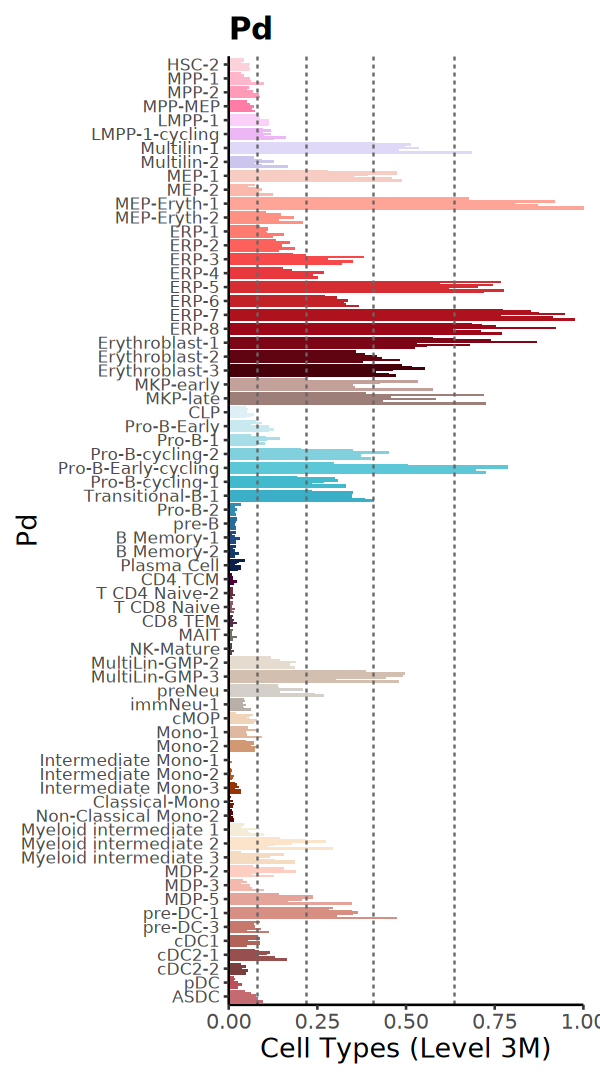

In [13]:
library(classInt)

#------------------------
jenks_breaks <- classInt::classIntervals(combined_df$prop2div, n = 5, 
                                         style = "jenks")

combined_df$jenks_group <- cut(combined_df$prop2div,
                                  breaks = jenks_breaks$brks,
                                  include.lowest = TRUE,
                                  labels = paste0("Group ", 1:5))
combined_df$`Level 3M` <- factor(combined_df$`Level 3M`, levels = rev(labelorder))
jenks_y_breaks <- sort(jenks_breaks$brks)
#------------------------

barplot <- ggplot(combined_df, 
                  aes(x = `Level 3M`, 
                      y = prop2div, 
                      fill = `Level 3M`, 
                      group = `donor_id`)) +
  geom_bar(stat = "identity", 
           position = position_dodge(width = 0.8), 
           show.legend = FALSE) +
  scale_fill_manual(values = colorcode) +
  # Jenks separators
  geom_hline(yintercept = jenks_y_breaks[-c(1, length(jenks_y_breaks))], 
             linetype = "dashed", color = "gray40", linewidth = 0.5) +
  scale_y_continuous(expand = c(0, 0)) +
  coord_cartesian(ylim = c(0, max(combined_df$prop2div, na.rm = TRUE))) +
  coord_flip() +
  theme_classic() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.text.x = element_text(size = 12),
    axis.title.y = element_text(size = 16),
    axis.title.x = element_text(size = 16),
    plot.title = element_text(size = 18, face = "bold"),
    plot.margin = margin(10, 10, 10, 10)
  ) +
  labs(x = "Pd", y = "Cell Types (Level 3M)", title = "Pd")

fig (5,9)
barplot

In [14]:
jenks_breaks

style: jenks
        [0,0.0818961] (0.0818961,0.2205019]  (0.2205019,0.407267] 
                  251                   110                    64 
 (0.407267,0.6360495]         (0.6360495,1] 
                   42                    34 

In [15]:
colnames(combined_df)


[1] "sample"           "avg_zscore"       "donor_id"         "Level 3M"        
 [5] "Level 2"          "Level 1"          "study"            "sex"             
 [9] "age"              "disease"          "disease_category" "age_category"    
[13] "age_ontology"     "blasts_pct"       "risk"             "psbulk_n_cells"  
[17] "psbulk_counts"    "cell_type"        "prop2div"         "jenks_group"

In [16]:
combined_df$cell_type <- as.character(combined_df$cell_type)
combined_df$cell_type <- factor(combined_df$cell_type, levels = labelorder)

combined_df <- combined_df[order(combined_df$cell_type), ]


In [17]:
head(combined_df)

,sample,avg_zscore,donor_id,Level 3M,Level 2,Level 1,study,sex,age,disease,disease_category,age_category,age_ontology,blasts_pct,risk,psbulk_n_cells,psbulk_counts,cell_type,prop2div,jenks_group
,<chr>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>
21,BM1_HSC-2,-0.4764985,BM1,HSC-2,HSPC,HSC,HCA,F,52.0,healthy,healthy,middle aged (40-60),HsapDv:0000267,healthy,healthy,115,995452,HSC-2,0.05956209,Group 1
85,BM2_HSC-2,-0.5964394,BM2,HSC-2,HSPC,HSC,HCA,M,50.0,healthy,healthy,middle aged (40-60),HsapDv:0000267,healthy,healthy,17,120417,HSC-2,0.02891108,Group 1
135,BM3_HSC-2,-0.4912115,BM3,HSC-2,HSPC,HSC,HCA,M,39.0,healthy,healthy,young adult (15-39),HsapDv:0000266,healthy,healthy,73,532652,HSC-2,0.05580216,Group 1
192,BM4_HSC-2,-0.5827134,BM4,HSC-2,HSPC,HSC,HCA,M,29.0,healthy,healthy,young adult (15-39),HsapDv:0000266,healthy,healthy,88,579648,HSC-2,0.03241877,Group 1
259,BM5_HSC-2,-0.4792668,BM5,HSC-2,HSPC,HSC,HCA,M,29.0,healthy,healthy,young adult (15-39),HsapDv:0000266,healthy,healthy,104,854768,HSC-2,0.05885464,Group 1
324,BM6_HSC-2,-0.5774851,BM6,HSC-2,HSPC,HSC,HCA,F,26.0,healthy,healthy,young adult (15-39),HsapDv:0000266,healthy,healthy,136,985072,HSC-2,0.03375486,Group 1


In [18]:
#write.table (combined_df, "./data/sampleinfo_with_Pd.tsv",
#             sep = "\t")

In [19]:
library(dplyr)

summary_stats <- combined_df %>%
  group_by(cell_type) %>%
  summarise(
    mean_prop2div = mean(prop2div, na.rm = TRUE),
    median_prop2div = median(prop2div, na.rm = TRUE)
  )

combined_df <- combined_df %>%
  left_join(summary_stats, by = "cell_type")


In [20]:
summary_stats

cell_type,mean_prop2div,median_prop2div
<fct>,<dbl>,<dbl>
HSC-2,0.04402435,0.04144558
MPP-1,0.05121577,0.04308683
MPP-2,0.06188620,0.05680169
MPP-MEP,0.05739775,0.05745723
LMPP-1,0.09347260,0.08676426
LMPP-1-cycling,0.11611801,0.11833807
Multilin-1,0.49564365,0.49681037
Multilin-2,0.09761670,0.09110900
MEP-1,0.40751715,0.42645899


In [21]:
#write.table (summary_stats, "./data/TableS2_Pd_mean_median.tsv", 
#             sep = "\t")

In [22]:
jenks_result <- classIntervals(combined_df$prop2div, 
                               n = 5, style = "jenks")

jenks_result$brks

[1] 0.0000000 0.0818961 0.2205019 0.4072670 0.6360495 1.0000000

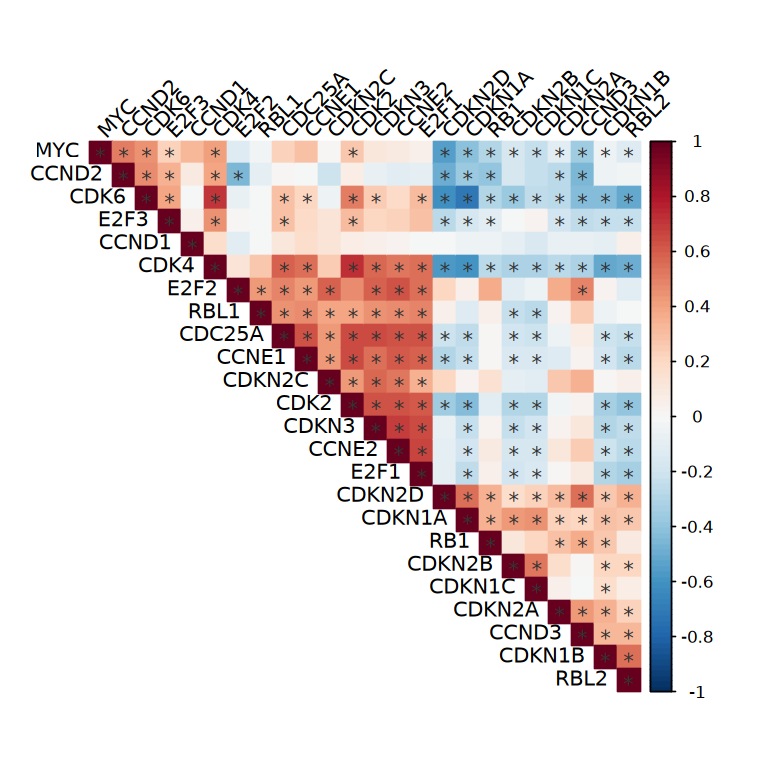

In [24]:
G1Sgenes = c("CCND1","CCND2","CCND3","CCNE1","CCNE2", #cyclins
           "RB1","RBL1","RBL2", #RB related proteins
           "CDK2","CDK4","CDK6",
           "E2F1","E2F2","E2F3",
            "CDC25A","CDKN1A","CDKN1B","CDKN1C","CDKN2A","CDKN2B","CDKN2C","CDKN2D","CDKN3", "MYC")

#cpm <- cpm(y, normalized.lib.sizes=TRUE)

logcpm_CC = logcpm[G1Sgenes,]
logcpm_CC_t = t(logcpm_CC)

logCPM_sc <- t(scale(t(logcpm_CC)))

#-------
correlaciones <- cor(logcpm_CC_t,
                      method = "pearson"#,
                    #use = "pairwise.complete.obs"
                    )

#  hierarchical clustering on the corr matrix
hc <- hclust(as.dist(1 - correlaciones))
gene_order <- hc$order
gene_names <- rownames(correlaciones)[gene_order]  #  gene names in clustered order

#swap CDC25A and CDK2
swap_idx1 <- which(gene_names == "CDKN2C")
swap_idx2 <- which(gene_names == "CDK4")
gene_names[c(swap_idx1, swap_idx2)] <- gene_names[c(swap_idx2, swap_idx1)]

reversed_gene_names <- rev(gene_names)

correlaciones_reversed <- correlaciones[reversed_gene_names, reversed_gene_names]

testRes = cor.mtest(correlaciones_reversed, conf.level = 0.99)

# adj p-val
adjusted_pvalues <- p.adjust(testRes$p, method = "BH")

# 
adjusted_pvalues_matrix <- matrix(adjusted_pvalues, nrow = nrow(correlaciones_reversed), ncol = ncol(correlaciones_reversed))

colnames(adjusted_pvalues_matrix) <- colnames(correlaciones_reversed)
rownames(adjusted_pvalues_matrix) <- rownames(correlaciones_reversed)

fig (6.5,6.5)
corrplot(correlaciones_reversed, 
         p.mat = adjusted_pvalues_matrix, 
         sig.level = c(0.01), pch.cex = 1,
         tl.col="black", tl.srt=45,
         method = 'color', diag = TRUE, 
         type = 'upper',
         insig = 'label_sig', pch.col = 'grey20', 
         col = colorRampPalette(rev(brewer.pal(n=11, name="RdBu")))(100))  # smooth gradient


In [ ]:
#pdf("./data/correlation_plot_v2.pdf", width = 6, height = 6)
#
#corrplot(correlaciones_reversed, 
#         p.mat = adjusted_pvalues_matrix, 
#         sig.level = 0.01, pch.cex = 1,
#         tl.col = "black", tl.srt = 45,
#         method = 'color', diag = TRUE, 
#         type = 'upper',
#         insig = 'label_sig', pch.col = 'grey20', 
#         col = colorRampPalette(rev(brewer.pal(n = 11, name = "RdBu")))(100))
#
#dev.off()


In [25]:
correlaciones_reversed

,MYC,CCND2,CDK6,E2F3,CCND1,CDK4,E2F2,RBL1,CDC25A,CCNE1,⋯,E2F1,CDKN2D,CDKN1A,RB1,CDKN2B,CDKN1C,CDKN2A,CCND3,CDKN1B,RBL2
MYC,1.000000000,0.51560979,0.441371452,2.203087e-01,0.323564749,0.4157523,-0.12608078,-2.635669e-02,0.23945778,0.283681849,⋯,0.0442989588,-0.55306645,-0.40273838,-0.281696475,-0.171263442,-0.220134141,-0.1011154787,-0.345739239,-0.0512101318,-0.12853007
CCND2,0.515609786,1.00000000,0.466938712,3.530481e-01,0.098645327,0.3908362,-0.45122938,-9.830923e-02,0.01702975,-0.010806150,⋯,-0.0871437986,-0.49372071,-0.36523054,-0.394376503,-0.164134650,-0.229231717,-0.2687254271,-0.441396365,-0.0566373397,-0.02808266
CDK6,0.441371452,0.46693871,1.000000000,3.825577e-01,-0.009967924,0.7135632,-0.06322291,-2.796340e-04,0.28208307,0.213492245,⋯,0.3106115446,-0.60091402,-0.70651061,-0.288191120,-0.368773300,-0.254281604,-0.2608489785,-0.439054671,-0.4339511284,-0.51039613
E2F3,0.220308653,0.35304811,0.382557693,1.000000e+00,0.054264594,0.4568564,0.01560654,-9.016497e-06,0.28204325,0.189140576,⋯,0.2812304422,-0.27349801,-0.16325828,-0.119135299,-0.006561438,0.038074001,-0.1848815143,-0.257482016,-0.2380539181,-0.22607564
CCND1,0.323564749,0.09864533,-0.009967924,5.426459e-02,1.000000000,0.1745977,-0.11742969,-4.345666e-03,0.11705770,0.160627114,⋯,-0.0027915744,-0.01785067,-0.04853854,-0.042092511,-0.096194870,-0.142783231,-0.0765054804,-0.068289316,-0.0945645127,0.05366538
CDK4,0.415752313,0.39083624,0.713563152,4.568564e-01,0.174597714,1.0000000,0.12839751,2.625959e-01,0.59036566,0.559388618,⋯,0.5523165715,-0.57346597,-0.58420498,-0.268656141,-0.319005079,-0.306806336,-0.2735050450,-0.309033926,-0.5098595951,-0.48421524
E2F2,-0.126080785,-0.45122938,-0.063222908,1.560654e-02,-0.117429688,0.1283975,1.00000000,4.239048e-01,0.48599884,0.432060355,⋯,0.5435214587,0.20801406,0.05957259,0.364883881,-0.115155445,-0.056351726,0.3767747793,0.494455762,0.0374791491,-0.10224227
RBL1,-0.026356695,-0.09830923,-0.000279634,-9.016497e-06,-0.004345666,0.2625959,0.42390483,1.000000e+00,0.45681039,0.466144353,⋯,0.4983749588,0.05910832,-0.13547313,0.045783372,-0.220733208,-0.275157816,0.0277983341,0.246840221,-0.0492155446,-0.01408461
CDC25A,0.239457785,0.01702975,0.282083072,2.820433e-01,0.117057705,0.5903657,0.48599884,4.568104e-01,1.00000000,0.629339868,⋯,0.6300258086,-0.21152320,-0.24550443,0.011535344,-0.188560129,-0.207711498,-0.0596122667,0.071072146,-0.2046842669,-0.22924629
CCNE1,0.283681849,-0.01080615,0.213492245,1.891406e-01,0.160627114,0.5593886,0.43206036,4.661444e-01,0.62933987,1.000000000,⋯,0.5813650057,-0.28967715,-0.22647503,0.009214411,-0.142626074,-0.145226702,-0.1204891933,0.035719319,-0.1820065953,-0.26040034


## Ternary plot

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


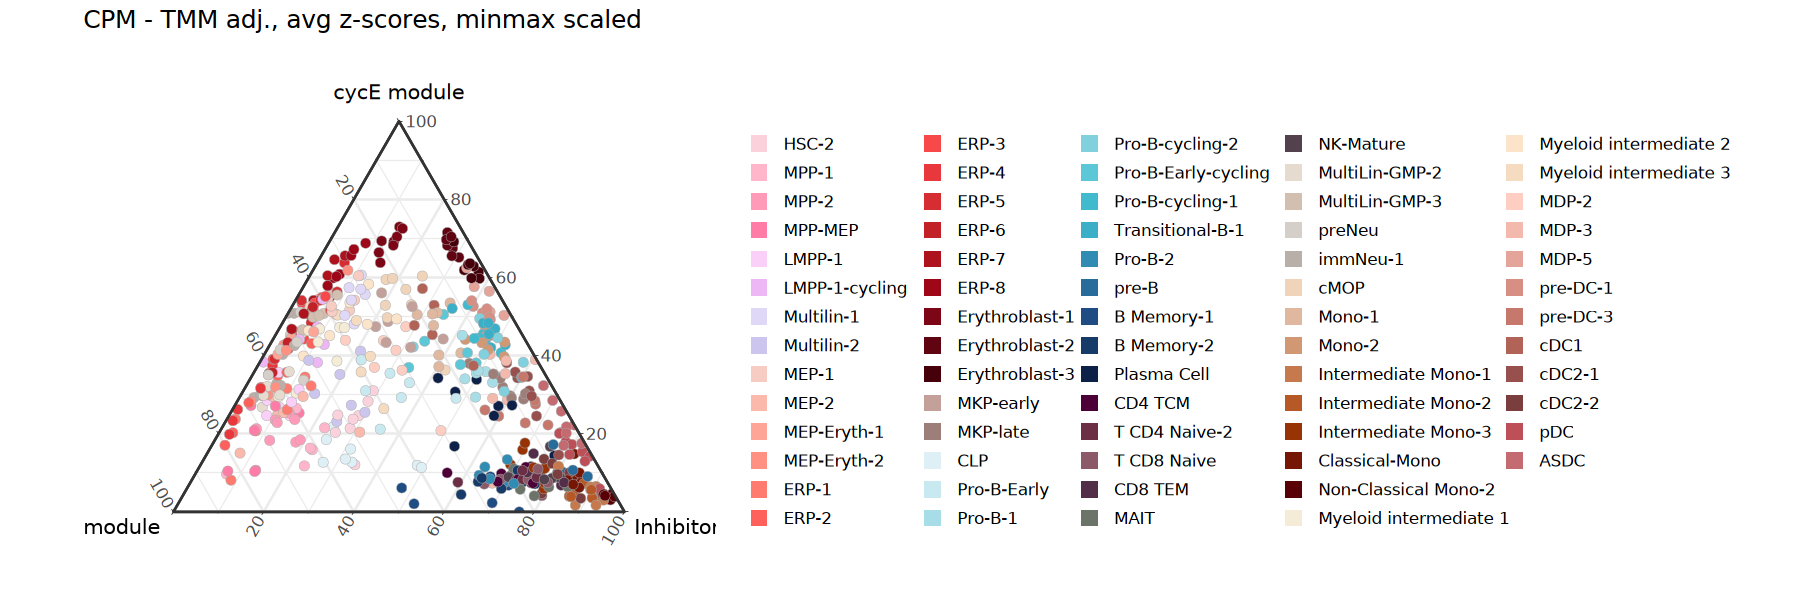

In [74]:
cycD_module <- c("CCND1", "CCND2", "CDK6", "MYC", "E2F3")

cycE_module <- c("CCNE1", "CCNE2", 
                 "CDK2", "CDK4", 
                 "CDC25A", "E2F1", "E2F2", 
                 "RBL1", "CDKN2C","CDKN3")

inhibitors_module <- c("RB1", "RBL2", 
                       "CDKN1B", "CDKN1C", "CDKN2A", "CDKN2B", "CDKN2D", "CCND3","CDKN1A")
#---------------------------------------

G1Sgenes = c("CCND1","CCND2","CCND3","CCNE1","CCNE2", #cyclins
           "RB1","RBL1","RBL2", #RB related proteins
           "CDK2","CDK4","CDK6",
           "E2F1","E2F2","E2F3",
            "CDC25A","CDKN1A","CDKN1B","CDKN1C","CDKN2A","CDKN2B","CDKN2C","CDKN2D","CDKN3", "MYC")

cpm <- cpm(y, normalized.lib.sizes=TRUE)

cpm_pink = cpm[G1Sgenes,]
cpm_pink_sc <- t(scale(t(cpm_pink)))
#head(cpm_pink)

logCPM_df <- as.data.frame(cpm_pink) %>%
  rownames_to_column(var = "gene") %>%  
  mutate(module = case_when(
    gene %in% cycE_module ~ "CycE",
    gene %in% cycD_module ~ "CycD",
    gene %in% inhibitors_module ~ "Inhibitors",
    TRUE ~ NA_character_  
  )) #%>%
 # filter(!is.na(module))  

# the average z-score per sample and module
module_avg_df <- logCPM_df %>%
  pivot_longer(cols = -c(gene, module), 
               names_to = "sample", 
               values_to = "z_score") %>%
  group_by(sample, module) %>%
  summarise(avg_z_score = mean(z_score, na.rm = TRUE), 
            .groups = "drop") %>%
  pivot_wider(names_from = module, values_from = avg_z_score)

module_avg_df_scaled <- module_avg_df %>%
  mutate(across(where(is.numeric), ~ (. - min(.)) / (max(.) - min(.))))


#---------
module_avg_df_minmax <- module_avg_df_scaled %>%
  mutate(
    total = CycD + CycE + Inhibitors,   # is 1
    CycD = CycD / total,               
    CycE = CycE / total,               
    Inhibitors = Inhibitors / total    
  ) %>%
  select(-total)  

combined_df <- merge(module_avg_df_minmax, sampleinfo, by = "sample")
combined_df$color <- colorcode[combined_df$cell_type]

combined_df$cell_type <- factor(combined_df$cell_type, 
                                levels = labelorder)

fig(15,5)
triangle = ggtern(data = combined_df, 
       aes(x = CycD, y = CycE, z = Inhibitors, color = cell_type, fill = cell_type)) +
  geom_point(shape = 21, size = 2.5, 
            color = "dark grey", stroke = 0.15) +  
  scale_fill_manual(values = colorcode) + 
  scale_color_manual(values = colorcode) +  
  labs(
    title = "CPM - TMM adj., avg z-scores, minmax scaled",
    x = "cycD module",
    y = "cycE module",
    z = "Inhibitors module"
  ) +
  theme_bw()+
  guides(
    fill = guide_legend(override.aes = list(size = 5, shape = 22, 
                                            stroke = 0), 
                        ncol = 5, title = "") )
triangle


In [19]:
head(cpm_pink)

,BM1_ASDC,BM2_ASDC,BM3_ASDC,BM4_ASDC,BM5_ASDC,BM6_ASDC,BM7_ASDC,BM8_ASDC,BM1_B Memory-1,BM2_B Memory-1,⋯,BM7_pre-DC-3,BM8_pre-DC-3,BM1_preNeu,BM2_preNeu,BM3_preNeu,BM4_preNeu,BM5_preNeu,BM6_preNeu,BM7_preNeu,BM8_preNeu
CCND1,5.89721,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,4.760797,⋯,11.546025,7.294646,0.000000,0.000000,0.000000,0.000000,0.9810295,0.000000,0.000000,0.000000
CCND2,5.89721,8.312453,7.296878,0.00000,2.762779,0.000000,16.375395,9.523001,10.91385,4.760797,⋯,3.848675,7.294646,65.792339,50.663054,96.573559,73.260628,102.0270705,82.966508,68.554830,112.769311
CCND3,271.27164,216.123774,113.101605,122.94385,168.529508,249.443188,225.161683,190.460013,185.53547,104.737535,⋯,130.854945,153.187560,16.726866,9.211464,8.277734,17.908154,12.7533838,19.146117,11.057231,21.387283
CCNE1,0.00000,0.000000,10.945317,0.00000,0.000000,5.307302,4.093849,6.348667,0.00000,0.000000,⋯,11.546025,3.647323,13.381493,4.605732,13.796223,4.884042,9.8102952,9.573059,4.422892,7.777194
CCNE2,0.00000,0.000000,7.296878,0.00000,11.051115,0.000000,0.000000,9.523001,0.00000,0.000000,⋯,3.848675,0.000000,6.690746,0.000000,2.759245,3.256028,7.8482362,4.786529,8.845785,3.888597
RB1,17.69163,24.937358,36.484389,27.32086,38.678904,15.921906,36.844639,28.569002,80.03491,80.933550,⋯,30.789399,18.236614,27.878110,13.817196,13.796223,17.908154,15.6964724,25.528156,15.480123,18.470835


In [20]:
head(sampleinfo)

,sample,donor_id,Level 3M,Level 2,Level 1,study,sex,age,disease,disease_category,age_category,age_ontology,blasts_pct,risk,psbulk_n_cells,psbulk_counts,cell_type
,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
1,BM1_ASDC,BM1,ASDC,Dendritic,ASDC,HCA,F,52.0,healthy,healthy,middle aged (40-60),HsapDv:0000267,healthy,healthy,14,128299,ASDC
2,BM2_ASDC,BM2,ASDC,Dendritic,ASDC,HCA,M,50.0,healthy,healthy,middle aged (40-60),HsapDv:0000267,healthy,healthy,13,94350,ASDC
3,BM3_ASDC,BM3,ASDC,Dendritic,ASDC,HCA,M,39.0,healthy,healthy,young adult (15-39),HsapDv:0000266,healthy,healthy,39,254625,ASDC
4,BM4_ASDC,BM4,ASDC,Dendritic,ASDC,HCA,M,29.0,healthy,healthy,young adult (15-39),HsapDv:0000266,healthy,healthy,29,165164,ASDC
5,BM5_ASDC,BM5,ASDC,Dendritic,ASDC,HCA,M,29.0,healthy,healthy,young adult (15-39),HsapDv:0000266,healthy,healthy,50,365020,ASDC
6,BM6_ASDC,BM6,ASDC,Dendritic,ASDC,HCA,F,26.0,healthy,healthy,young adult (15-39),HsapDv:0000266,healthy,healthy,23,143945,ASDC


In [ ]:
#ggsave (plot=triangle, 
#        "./data/triangle5.pdf", width = 15, height = 5)

In [123]:
load("./data/pbulk_env_v1.RData")


In [124]:
#Sun test

colors_myelo <- c(

  "HSC-2"   = "#fbd1dc",  
  "MPP-1"   = "#ffb6ca",  
  "MPP-2"   = "#ff9bb9",  
  "MPP-MEP" = "#ff7ca6",   

"LMPP-1"         = "#FAD0F8", 
"LMPP-1-cycling" = "#EDB6F4",  

"Multilin-1" = "#DFD8F6", 
"Multilin-2" = "#CCC5ED", 

  "MEP-1" = "#F7CDC3",
  "MEP-2" = "#ffb9ad",
  "MEP-Eryth-1" = "#ffa799",
  "MEP-Eryth-2" = "#ff9385",

  "ERP-1" = "#ff7c70",
  "ERP-2" = "#fe625b",
  "ERP-3" = "#fb4348",
  "ERP-4" = "#eb323d",
  "ERP-5" = "#d72833",
  "ERP-6" = "#c21e29",
  "ERP-7" = "#ac131f",
  "ERP-8" = "#930d1b",

  "Erythroblast-1" = "#780b17",
  "Erythroblast-2" = "#5c0712",
  "Erythroblast-3" = "#3e030b",


  # MKP 
  "MKP-early" = "#C4A09A",  
  "MKP-late" = "#9D7E78",  

  # lymphoid (B, T, NK)
  "CLP" = "#DEF0F5",  
  "Pro-B-Early" = "#c8e9f0",  
  "Pro-B-1" = "#a7dde7",  
  "Pro-B-cycling-2" = "#80d0de",  
  "Pro-B-Early-cycling" = "#5cc7d6",  
  "Pro-B-cycling-1" = "#42bace",  
  "Transitional-B-1" = "#3bafc7",  
  "Pro-B-2" = "#318cb4",  
  "pre-B" = "#276C9B",  
  "B Memory-1" = "#1F4C83",  
  "B Memory-2" = "#173B69",  
  "Plasma Cell" = "#0C2048",  

  # T & NK Cells
  "CD4 TCM" = "#4D0038",  
  "T CD4 Naive-2" = "#6C2E44",  
  "T CD8 Naive" = "#8C5968",  
  "CD8 TEM" = "#522E48",  
  "MAIT" = "#6C7469",  
  "NK-Mature" = "#53424d",  
 
  "MultiLin-GMP-2" = "#e5dbce",  
  "MultiLin-GMP-3" = "#D2BFAF",  
    
  "preNeu"    = "#d4cfc9",  
  "immNeu-1"  = "#b8b0a8",  

  "Myeloid intermediate 1" = "#F5ECD7",  
  "Myeloid intermediate 2" = "#FBE4CA",  
  "Myeloid intermediate 3" = "#F5DBBF",  

  # Myeloid 
  "cMOP" = "#F0D4BA",  
  "Mono-1" = "#E0B89F",  
  "Mono-2" = "#D29773",  
  "Intermediate Mono-1" = "#C5794C",  
  "Intermediate Mono-2" = "#B75926",  
  "Intermediate Mono-3" = "#983306",  
  "Classical-Mono" = "#761706",  
  "Non-Classical Mono-2" = "#590007",  

  # DCs
  "MDP-2"     = "#ffcec2",  
  "MDP-3"     = "#f3b9ad",
  "MDP-5"     = "#e5a499",
  "pre-DC-1"  = "#d78e83",
  "pre-DC-3"  = "#c7786c",

  "cDC1"      = "#b26358",
  "cDC2-1"    = "#97504d",
  "cDC2-2"    = "#7a3e3e",
    
  "ASDC" = "#C46A71",  

  "pDC" = "#BC4F57"  

)

#---------------------

myeloid_cell_types = names(colors_myelo)
cell_type_samples <- sampleinfo$sample[sampleinfo$cell_type %in% myeloid_cell_types]
logcpm_CC <- logcpm[G1Sgenes, cell_type_samples]

#head(logcpm_CC)

logCPM_sc <- t(scale(t(logcpm_CC)))

#---------------------------

sampleinfo_filtered <- sampleinfo[sampleinfo$sample %in% colnames(logcpm_CC), ]
sampleinfo_filtered$cell_type <- droplevels(sampleinfo_filtered$cell_type)

sampleinfo_filtered <- sampleinfo_filtered[match(colnames(logcpm_CC), sampleinfo_filtered$sample), ]

#--------------------------
sampleinfo_filtered$cell_type <- factor(sampleinfo_filtered$cell_type, levels = myeloid_cell_types)
#sampleinfo_filtered <- sampleinfo_filtered[match(colnames(logcpm_CC), sampleinfo_filtered$sample), ]
sampleinfo_filtered <- sampleinfo_filtered[match(colnames(logcpm_CC), sampleinfo_filtered$sample), ]



#-------------------------------------------
ann <- data.frame(sampleinfo_filtered$cell_type, 
                 #prop2div_score,  sampleinfo_filtered$
                  sampleinfo_filtered$donor_id)
colnames(ann) <- c('cell_type','donor_id') #essential"Pd",
             #"Pd" = prop2div_score,  
               
colours = list('cell_type' = colors_myelo,
              # "Pd" = prop2div_score, # 
               'donor_id' = c("BM8" = "seashell",
                              "BM7" = "snow3",
                              "BM6" = "mistyrose2",
                              "BM5" = "moccasin",
                              "BM4" = "lightcyan1",
                              "BM3" = "tan",
                              "BM2" = "wheat",
                              "BM1" = "thistle"))

colAnn <- HeatmapAnnotation(
  df = ann,
  which = 'col',
  col = colours,
  annotation_width = unit(c(1, 4), 'cm'),
  gap = unit(1, 'mm'),
  annotation_legend_param = list(nrow = 1)  
)
#-------------------------------------------

cycD_module <- c("MYC", "CCND2", "CDK6", "E2F3","CCND1")

cycE_module <- c("CDK4", "E2F2", "RBL1", "CDC25A", "CCNE1","CDKN2C","CDK2","CDKN3", "CCNE2", "E2F1")

inhibitors_module <- c("CDKN2D", "CDKN1A", "RB1","CDKN2B","CDKN1C","CDKN2A","CCND3", "CDKN1B", "RBL2")


modules <- list(
  "CycE" = cycE_module,
  "CycD" = cycD_module,
  "Inhibitors" = inhibitors_module
)

gene_to_module <- rep(NA, nrow(logCPM_sc)) 
rownames(logCPM_sc) <- rownames(logCPM_sc) 

for (module_name in names(modules)) {
  module_genes <- modules[[module_name]]
  gene_to_module[rownames(logCPM_sc) %in% module_genes] <- module_name
}

gene_to_module[is.na(gene_to_module)] <- "Unassigned"

#------------------

fig (13,6.3)

library("RColorBrewer")

# Clip values in the matrix 
scaledata_matrix_clipped <- pmin(pmax(logCPM_sc, -2), 2)

col <- rev(colorRampPalette(brewer.pal(10, "RdYlBu"))(100))

set.seed (42)
#---------------------

ann$cell_type <- droplevels(ann$cell_type)

dend1 = cluster_within_group(scaledata_matrix_clipped,
                               ann$cell_type)
dend1

ncol(scaledata_matrix_clipped) == length(ann$cell_type)

#--------------------
ann$cell_type <- factor(ann$cell_type, levels = myeloid_cell_types)

'dendrogram' with 2 branches and 501 members total, at height 9.451282 

[1] TRUE

In [125]:
library("RColorBrewer")

In [126]:
sampleinfo_filtered_new <- sampleinfo_filtered %>%
  left_join(combined_Pd_df %>% select(sample, prop2div), by = "sample")

head(sampleinfo_filtered_new)

,sample,donor_id,Level 3M,Level 2,Level 1,study,sex,age,disease,disease_category,age_category,age_ontology,blasts_pct,risk,psbulk_n_cells,psbulk_counts,cell_type,prop2div
,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
1,BM1_ASDC,BM1,ASDC,Dendritic,ASDC,HCA,F,52.0,healthy,healthy,middle aged (40-60),HsapDv:0000267,healthy,healthy,14,128299,ASDC,0.09647557
2,BM2_ASDC,BM2,ASDC,Dendritic,ASDC,HCA,M,50.0,healthy,healthy,middle aged (40-60),HsapDv:0000267,healthy,healthy,13,94350,ASDC,0.03431773
3,BM3_ASDC,BM3,ASDC,Dendritic,ASDC,HCA,M,39.0,healthy,healthy,young adult (15-39),HsapDv:0000266,healthy,healthy,39,254625,ASDC,0.07986104
4,BM4_ASDC,BM4,ASDC,Dendritic,ASDC,HCA,M,29.0,healthy,healthy,young adult (15-39),HsapDv:0000266,healthy,healthy,29,165164,ASDC,0.05848280
5,BM5_ASDC,BM5,ASDC,Dendritic,ASDC,HCA,M,29.0,healthy,healthy,young adult (15-39),HsapDv:0000266,healthy,healthy,50,365020,ASDC,0.07504536
6,BM6_ASDC,BM6,ASDC,Dendritic,ASDC,HCA,F,26.0,healthy,healthy,young adult (15-39),HsapDv:0000266,healthy,healthy,23,143945,ASDC,0.02525038


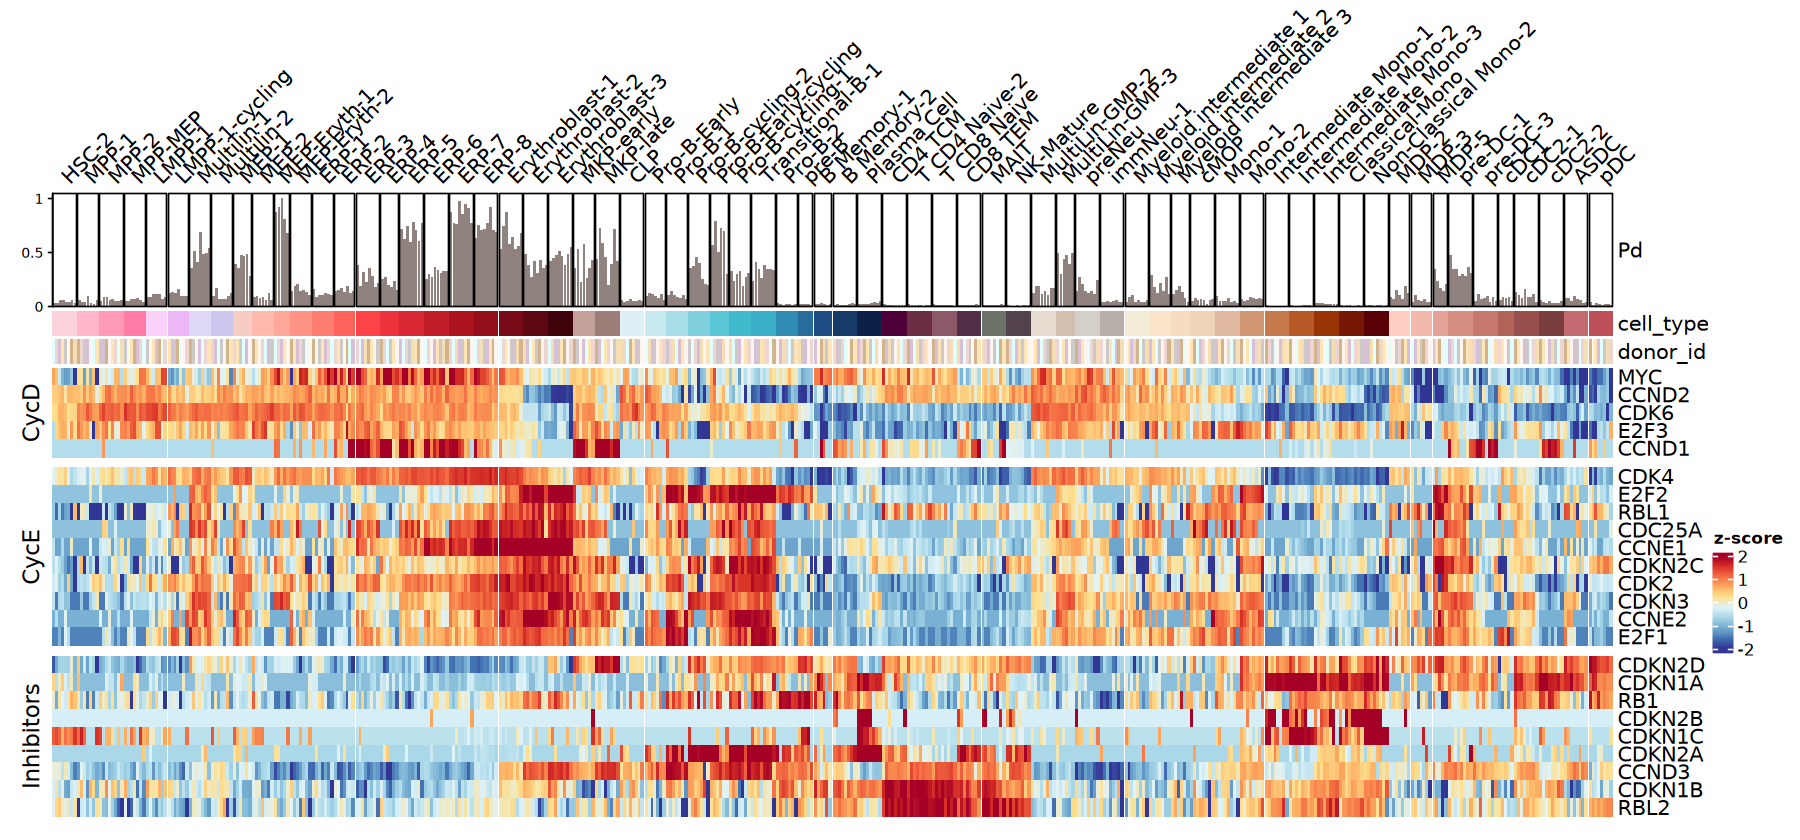

In [134]:
cycD_module <- c("MYC", "CCND2", "CDK6", "E2F3","CCND1")
cycE_module <- c("CDK4", "E2F2", "RBL1", "CDC25A", "CCNE1", "CDKN2C", "CDK2", "CDKN3", "CCNE2", "E2F1")
inhibitors_module <- c("CDKN2D", "CDKN1A", "RB1", "CDKN2B", "CDKN1C", "CDKN2A", "CCND3", "CDKN1B", "RBL2")

gene_to_module <- c(
  setNames(rep("CycD", length(cycD_module)), cycD_module),
  setNames(rep("CycE", length(cycE_module)), cycE_module),
  setNames(rep("Inhibitors", length(inhibitors_module)), inhibitors_module)
)

gene_order <- c(cycD_module, cycE_module, inhibitors_module)

scaledata_matrix_ordered <- scaledata_matrix_clipped[gene_order, ]

gene_to_module_ordered <- factor(gene_to_module[gene_order], levels = c("CycD", "CycE", "Inhibitors"))

ht <- Heatmap(
    scaledata_matrix_ordered,
    name = "z-score",  
    column_split = ann$cell_type,
    row_split = gene_to_module_ordered,  # Split rows in order
    cluster_rows = FALSE,
    cluster_row_slices = FALSE,
    cluster_column_slices = FALSE,
    show_row_dend = FALSE,
    show_column_dend = FALSE,
    column_title_gp = gpar(fontsize = 12),
    row_names_gp = gpar(fontsize = 12, family = "Sans", fontface = "italic"), 
    column_gap = unit(0.25, "mm"),
    row_gap = unit(2.2, "mm"),
    col = col,
    column_names_gp = gpar(fontsize = 15),
    column_title_rot = 45,
    show_column_names = FALSE,
    top_annotation = HeatmapAnnotation(
        Pd = anno_barplot(
            sampleinfo_filtered_new$prop2div, 
            axis = TRUE,
            gp = gpar(border = FALSE, fill = "#90827F", lty = "blank"),
            height = unit(2.4, "cm")
        ),
        show_legend = FALSE,
        df = ann,
        col = colours,
        annotation_width = unit(c(1, 4), 'cm'),
        gap = unit(1, 'mm')
    )
)

draw(ht, padding = unit(c(5, 5, 5, 5), "mm"))

In [136]:
pdf("./data/heatmap_output.pdf", width = 15, height = 7)
draw(ht, padding = unit(c(5, 5, 5, 5), "mm"))
dev.off()


pdf 
  2